In [1]:
from utils.preprocess_data import load_dataset
from utils.plots import plot_results
import numpy as np
from tensorflow.python.keras import Sequential, layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tensorflow import convert_to_tensor
from keras.models import load_model
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import os
import pandas as pd
import time

Loading data for all models

In [2]:
train_data = load_dataset(split="train")
val_data = load_dataset(split="valid")
features = ["xR","yR","theta"]
errors = []

### LSTM 

Some settings and variables for training

In [3]:
scaler_x = StandardScaler()
scaler_y = StandardScaler() 
sequence_length = 50
epochs = 30
batch_size = 32
load_lstm = True
load_model_path = "models/lstm.keras"
save_lstm = False
save_model_path = "models/lstm.keras"

Some helper functions for data preparation

In [4]:
def prepare_data(train_data, val_data):
    
    train_trials = train_data.index.get_level_values('trial_num').unique()
    val_trials = val_data.index.get_level_values('trial_num').unique()

    X_train = []
    y_train = []

    for trial_num in train_trials:
        x = train_data.loc[trial_num, features].to_numpy()
        y = train_data.loc[trial_num,["xV","yV"]].to_numpy()

        x =  create_sequences(data=x)
        y = y[sequence_length:]

        X_train.append(x)
        y_train.append(y)
        

    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    X_val = []
    y_val = []
    
    for trial_num in val_trials:
        x = val_data.loc[trial_num,features].to_numpy()
        y = val_data.loc[trial_num,["xV","yV"]].to_numpy()

        x =  create_sequences(data=x)
        y = y[sequence_length:]
        X_val.append(x)
        y_val.append(y)
        

    X_val = np.concatenate(X_val, axis=0)
    y_val = np.concatenate(y_val, axis=0)
    # TODO improve scaling 
    X_train_shape = X_train.shape

    # Reshape your data
    X_train= X_train.reshape(-1, len(features))
    X_train = scaler_x.fit_transform(X_train)
    X_train = X_train.reshape(X_train_shape)

    X_val_shape = X_val.shape
    X_val = X_val.reshape(-1, len(features))
    X_val = scaler_x.transform(X_val)
    X_val = X_val.reshape(X_val_shape)

    y_train = scaler_y.fit_transform(y_train)
    y_val = scaler_y.transform(y_val)

    return X_train, y_train, X_val, y_val

def create_sequences(data):
    sequences = []
    for i in range(sequence_length, len(data)):
        seq = data[i-sequence_length:i]
        sequences.append(seq)
    return np.array(sequences)

In [5]:
X_train, y_train, X_val, y_val = prepare_data(train_data, val_data)

In [6]:
if load_lstm:
    try:
        lstm_model = load_model(load_model_path)
        print(f"Successfully loaded model from {load_model_path}")
    except OSError:
        print(f"Couldn't find a model in <{load_model_path}>, please check the path or set load_model=False to train a new model")
else:
    lstm_model = Sequential([
        layers.LSTM(16, input_shape=X_train.shape[1:], return_sequences=True),
        layers.LSTM(16, return_sequences=True),
        layers.LSTM(16, return_sequences=False),
        layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(y_train.shape[1])  
    ])

    lstm_model.compile(optimizer='adam', loss='mean_absolute_error')

    history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    if save_lstm:
        lstm_model.save(save_model_path)


Successfully loaded model from models/lstm.keras


In [7]:
def predict(x):
    x = create_sequences(x)
    x_shape = x.shape
    x = x.reshape(-1, len(features))
    x = scaler_x.transform(x)
    x = x.reshape(x_shape)

    
    prediction = lstm_model.call(convert_to_tensor(x))
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

on validation dataset

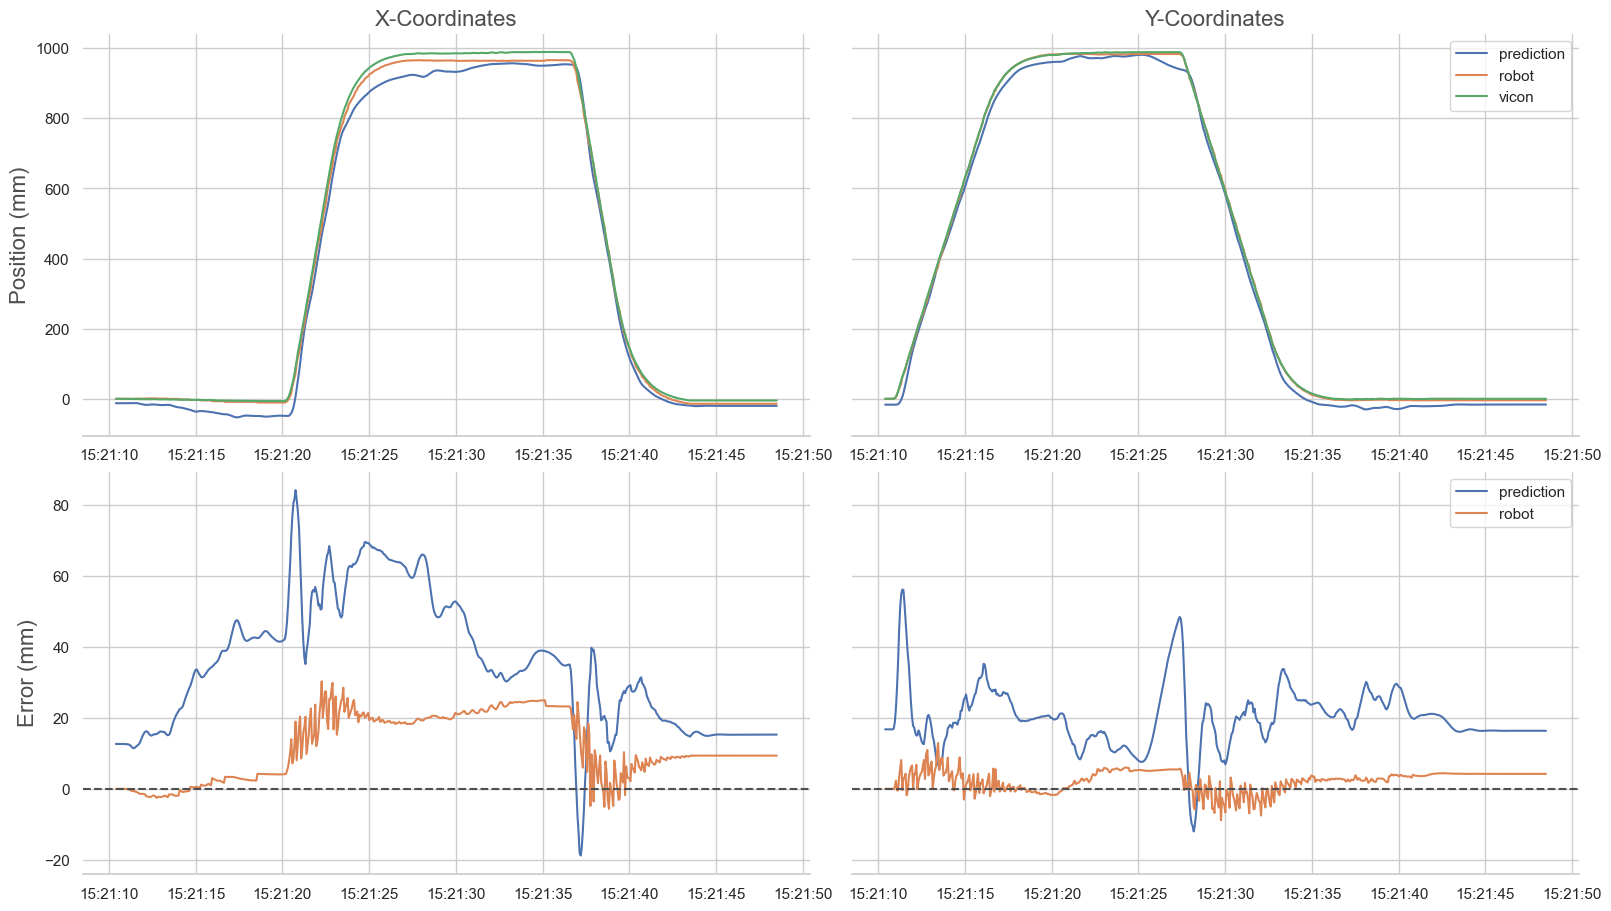

In [8]:
trial_num = 2
x_robot = val_data.loc[trial_num,["xR","yR"]].to_numpy()
prediction = predict(x=val_data.loc[trial_num,features].to_numpy())
vicon = val_data.loc[trial_num,["xV","yV"]].to_numpy()
time_axis = val_data.loc[trial_num,["tStart_datetime"]].to_numpy()


plot_results(time_axis[sequence_length:], prediction, x_robot[sequence_length:], vicon[sequence_length:], euclidean=False)

mae_lstm = mean_absolute_error(y_true=vicon[sequence_length:],y_pred=prediction,multioutput="raw_values")
mae_robot = mean_absolute_error(y_true=vicon[sequence_length:],y_pred=x_robot[sequence_length:],multioutput="raw_values")

errors.append({"model":"lstm","trial_num":trial_num, "mae_x": mae_lstm[0], "mae_y": mae_lstm[1],"mae_x_robot": mae_robot[0], "mae_y_robot": mae_robot[1]})

# Results

## Train

In [9]:
results_train = []
for trial_num in range(len(os.listdir("data/train"))):
    predictions = predict(train_data.loc[trial_num,features].to_numpy())
    robot = train_data.loc[trial_num, ["xR","yR"]].to_numpy()
    vicon = train_data.loc[trial_num, ["xV","yV"]].to_numpy()
    
    mae_lstm = mean_absolute_error(y_true=vicon[sequence_length:],y_pred=predictions,multioutput="raw_values")
    mae_robot = mean_absolute_error(y_true=vicon[sequence_length:],y_pred=robot[sequence_length:],multioutput="raw_values")

    final_error_robot = abs(vicon[-1] - robot[-1])
    final_error_lstm = abs(vicon[-1] - predictions[-1])



    results_train.append({
        "mae_robot_x": mae_robot[0],
        "mae_robot_y": mae_robot[1],
        "fe_robot_x": final_error_robot[0],
        "fe_robot_y": final_error_robot[1],

        "mae_lstm_x": mae_lstm[0],
        "mae_lstm_y": mae_lstm[1],
        "fe_lstm_x": final_error_lstm[0],
        "fe_lstm_y": final_error_lstm[1],
        
    })

df_results_train = pd.DataFrame(results_train)

# Calculate averages for each column
averages = df_results_train.mean()

# Append the averages as a new row to the DataFrame
df_results_train = df_results_train.append(np.round(averages,2), ignore_index=True)


df_results_train


C:\Users\nowak\AppData\Local\Temp\ipykernel_5960\1421198956.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_train = df_results_train.append(np.round(averages,2), ignore_index=True)


,mae_robot_x,mae_robot_y,fe_robot_x,fe_robot_y,mae_lstm_x,mae_lstm_y,fe_lstm_x,fe_lstm_y
0,14.317268,13.947297,17.260058,3.675243,17.000743,16.875675,7.853725,8.530253
1,25.758594,12.273970,21.227883,3.436640,14.940075,16.424579,4.756710,5.669537
2,16.059894,17.058154,17.028194,25.234419,19.625495,13.404957,7.748596,3.944439
3,5.324928,7.436780,7.032913,5.751636,21.684888,16.124805,13.045753,6.677850
4,11.338914,6.635513,1.630173,3.194891,15.689799,10.481049,2.977472,0.272518
5,6.781176,7.911737,0.020297,13.582291,15.629653,9.514153,5.620865,5.778036
6,5.597508,4.086829,1.526055,2.652775,19.503637,15.585545,5.400767,4.364489
7,8.730151,11.679196,16.202633,13.067896,19.239390,9.735266,3.905255,1.129827
8,11.740000,10.130000,10.240000,8.820000,17.910000,13.520000,6.410000,4.550000


## Validation

In [10]:
results_val = []
for trial_num in range(len(os.listdir("data/valid"))):
    predictions = predict(val_data.loc[trial_num,features].to_numpy())
    robot = val_data.loc[trial_num, ["xR","yR"]].to_numpy()
    vicon = val_data.loc[trial_num, ["xV","yV"]].to_numpy()
    
    mae_lstm = mean_absolute_error(y_true=vicon[sequence_length:],y_pred=predictions,multioutput="raw_values")
    mae_robot = mean_absolute_error(y_true=vicon[sequence_length:],y_pred=robot[sequence_length:],multioutput="raw_values")

    final_error_robot = abs(vicon[-1] - robot[-1])
    final_error_lstm = abs(vicon[-1] - predictions[-1])



    results_val.append({
        "mae_robot_x": mae_robot[0],
        "mae_robot_y": mae_robot[1],
        "fe_robot_x": final_error_robot[0],
        "fe_robot_y": final_error_robot[1],

        "mae_lstm_x": mae_lstm[0],
        "mae_lstm_y": mae_lstm[1],
        "fe_lstm_x": final_error_lstm[0],
        "fe_lstm_y": final_error_lstm[1],
        
    })

df_results_val = pd.DataFrame(results_val)

# Calculate averages for each column
averages = df_results_val.mean()

# Append the averages as a new row to the DataFrame
df_results_val = df_results_val.append(np.round(averages,2), ignore_index=True)


df_results_val


C:\Users\nowak\AppData\Local\Temp\ipykernel_5960\3644100752.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_val = df_results_val.append(np.round(averages,2), ignore_index=True)


,mae_robot_x,mae_robot_y,fe_robot_x,fe_robot_y,mae_lstm_x,mae_lstm_y,fe_lstm_x,fe_lstm_y
0,3.366457,5.870627,4.637420,3.786709,22.184938,25.320440,11.857097,10.544002
1,11.240706,7.126749,8.038522,6.942160,15.504787,10.333342,2.864250,0.420803
2,12.156226,3.242938,9.367689,4.212245,35.298246,20.244886,15.295988,16.366445
3,8.920000,5.410000,7.350000,4.980000,24.330000,18.630000,10.010000,9.110000


## Inference Time

In [14]:
test_input = np.zeros((1, 50, 3))

inf_times = []
for i in range(100):
    t_start = time.time()
    lstm_model.call(convert_to_tensor(test_input))
    inf_times.append(time.time()-t_start)

print(f'Inference Time: {np.mean(inf_times)*1000}')


Inference Time: 906.7952132225037
